In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import matplotlib.patches as mpatches

In [4]:
import re

In [5]:
df_raw = pd.read_csv("broodswap_time_series.both_transitions.time_transition_interaction.genes.batch_corrected.vst.tbl",
                     delim_whitespace=True,
                    )

In [6]:
df_raw.columns = [ re.sub("_?Aligned.+", "", c) for c in df_raw.columns]

In [7]:
df_raw.head()

,P_B1_C16III_FL12_ctrlF_PE,P_B1_C16III_SP12_ctrlS_PE,P_B1_C16II_SP12_ctrlS_PE,P_B1_C16IV_FL12_ctrlF_PE,P_B1_C16IV_SP12_ctrlS_PE,P_B2_C16II_FL12_ctrlF_PE,P_B2_STC1II_FL12_ctrlF_PE,P_B2_STC1II_SP12_ctrlS_PE,P_B2_STC1IV_FL12_ctrlF_PE,P_B2_STC1IV_SP12_ctrlS_PE,...,R_B5_STC6_FL06_ctrlF_SE,R_B5_STC6_FP06,R_B5_STC6_FP12,R_B5_STC6_FP24,R_B5_STC6_FP48,R_B5_STC6_SL06,R_B5_STC6_SL12,R_B5_STC6_SL24,R_B5_STC6_SL48,R_B5_STC6_SP06_ctrlS_SE
LOC105274440,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,...,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982
LOC105274441,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,...,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982,5.085982
LOC105274442,10.905190,10.380246,10.405197,10.801879,10.609567,10.768184,10.137710,10.571775,10.305189,10.237224,...,11.017207,10.830813,10.968643,10.867662,10.803846,10.533719,10.459669,10.639170,10.853084,10.512849
LOC105274443,8.372844,8.308189,8.282998,8.435643,8.394106,7.977514,8.126495,7.845911,8.062545,7.472094,...,8.554849,8.575524,8.447316,8.623629,8.570467,8.519876,8.179190,8.576107,8.558299,8.401804
LOC105274444,10.814357,10.682050,10.617894,11.131137,10.583124,10.738391,11.145284,10.990279,11.310038,11.228436,...,10.958235,11.038798,11.231212,11.052154,11.197728,11.439101,11.301972,11.220380,11.388456,11.096076


In [8]:
def parse_treatment(name):
    s = re.search("([FSPL]{2}\d\d)", name)
    if s:
        return s.group(1)
    else:
        return None

In [9]:
df_mean = df_raw.groupby(parse_treatment, axis=1,).mean()

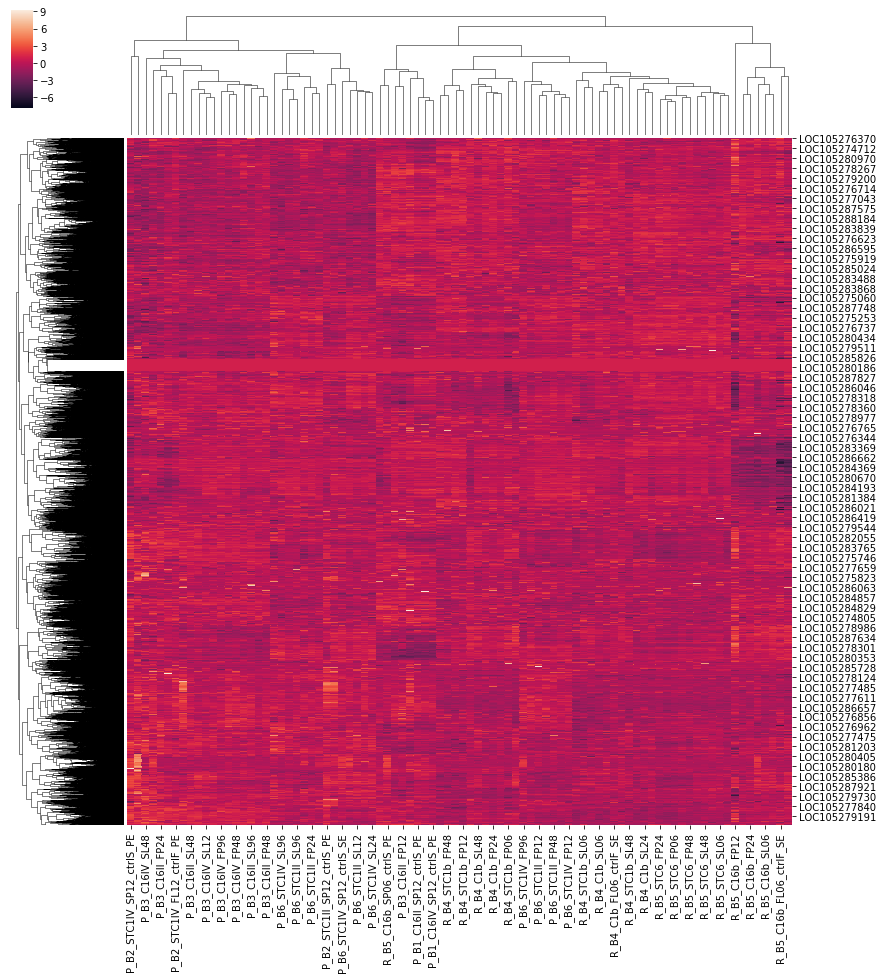

In [10]:
sns.clustermap(method='complete', metric='euclidean',
                data=df_raw, z_score=0, 
               figsize=(14,15)
              )

# Cluster analysis

In [11]:
from scipy.spatial.distance import pdist, squareform, warnings

In [12]:
from statsmodels.stats import outliers_influence
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [13]:
def standardize_data(data_c):
    """
    standardize expression values as above (z-score = 1)
    """
    std_scale = preprocessing.StandardScaler().fit(data_c.T)
    data_norm = std_scale.transform(data_c.T)
    return data_norm

In [14]:
def pca_transform(data_norm):
    pca_norm = PCA()
    pca_norm.fit(data_norm)
    pca_transformed = pca_norm.transform(data_norm)
    return pca_norm, pca_transformed

In [15]:
def view_pca_contribution(pca_norm):
    """
    view the contribution of each component
    """
    dim_no = len(pca_norm.explained_variance_ratio_)
    fig = plt.Figure(figsize=(13,4))
    plt.bar(np.arange(dim_no)+1,  pca_norm.explained_variance_ratio_, )
    plt.title("Proportion of variance explained by each component");
    plt.xticks(np.arange(130)+1)
    plt.xlim((0,dim_no))
    plt.xlabel("Component #")
    plt.ylabel("Proportion of variance explained")
    plt.tight_layout()
    plt.show()

## KMeans clustering

In [16]:
def extract_treatments(data_c):
    treatments = [ parse_treatment(name) for name in data_c.columns ]

    # list all unique values:
    S = pd.Series(treatments)
    print("{} unique names found:".format(S.nunique()))
    print(S.unique())
    
    # set known clusters:
    ordinals = {c: ordinal for ordinal, c in enumerate(set(treatments))}
    known_clusters = [ ordinals[c] for c in treatments ]
    
    return S.nunique(), S.unique(), treatments, known_clusters


In [17]:
def plot_clusters(pca_transformed, known_clusters, predicted_clusters, scheme="tab20", size=100):
    # set colors of groups
    cmap=plt.get_cmap("Accent")
    color_rgba = [ cmap(i) for i in known_clusters ]

    plt.figure(figsize=(30,12))

    # the first plot is colored by predicted clusters
    ax1 = plt.subplot2grid((1,4),(0,0), colspan=2)
    ax1.scatter(pca_transformed[:, 0], pca_transformed[:, 1],  c=make_colors(predicted_clusters, scheme=scheme),  s=size, alpha=0.9)

    # the second plot is colored by the known experimental groups
    ax2 = plt.subplot2grid((1,4),(0,2), colspan=2)
    ax2.scatter(pca_transformed[:, 0], pca_transformed[:, 1],  c=make_colors(known_clusters, scheme=scheme), s=size, alpha=0.9)

    # annotate to see groups
    for label,x,y in zip(treatments, 
                         pca_transformed[:, 0], pca_transformed[:, 1]):
        plt.annotate(label, xy=(x,y),xytext=(-5, 5),
            textcoords='offset points', ha='right', va='bottom',)

    plt.savefig("kmeans clustering on PCA plot.png")
    plt.show()

In [18]:
def plot_sample_distances(data_c, pca_transformed, known_clusters, treatments, scheme='tab20'):
    # calculate the distance between samples using PCA transformed genes
    pca_dist = pdist(pca_transformed, "correlation")
    pca_dist_square = squareform(pca_dist)
    pdist_df = pd.DataFrame(pca_dist_square, 
                            index=treatments, 
                            columns=treatments)

    ## plot distances
    # set colors
    cmap = sns.cubehelix_palette(as_cmap=True, rot=-.3, light=1, reverse=True)
    grp_colors = make_colors(known_clusters, scheme=scheme)
    
    
    # create clustermap
    figlen = int(2*np.log2(len(known_clusters)))*2
    cg = sns.clustermap(pdist_df, metric='euclidean', method="average",
                        row_colors=grp_colors, col_colors=grp_colors,
                        cmap=cmap, 
                        xticklabels=False,
                        yticklabels=data_c.columns, 
                        figsize=(figlen, figlen)
                       )

    # rotate y-axis labels
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    #plt.savefig("clustermap of PCA transformed data.png")
    plt.show()

In [19]:
def make_colors(values, scheme='tab20'):
    grp_cmap = plt.get_cmap(scheme)
    colors = [ grp_cmap(i/len(values)) for i in values]
    return colors 

In [20]:
def show_legend(known_clusters, treatments, scheme='tab20'):
    # create legend:
    grp_cmap = plt.get_cmap(scheme)
    colors = make_colors(known_clusters, scheme=scheme)
    patches = []
    for color, label in zip(colors, treatments):
        patches.append(mpatches.Patch(color=color, label=label))

    # create figure
    fig = plt.figure(figsize=(1, 1))
    ax= fig.add_subplot(111,)

    # make figure invisible:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for spine in ax.spines.values():
            spine.set_edgecolor('white')

    # draw figure + legend
    fig.legend(patches, treatments, loc='center', frameon=True, ncol=4)
    plt.show()


In [21]:
show_legend(known_clusters, treatments)

NameError: name 'known_clusters' is not defined

# Analysis of full dataset

In [22]:
data_norm = standardize_data(df_raw)

In [23]:
%%time
pca_norm, pca_transformed = pca_transform(data_norm)

CPU times: user 244 ms, sys: 32.7 ms, total: 277 ms
Wall time: 167 ms


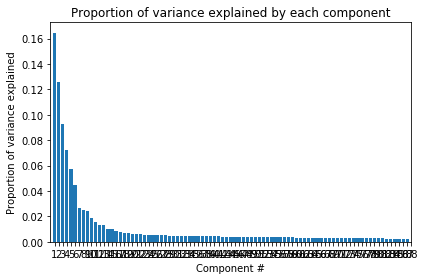

In [24]:
view_pca_contribution(pca_norm)

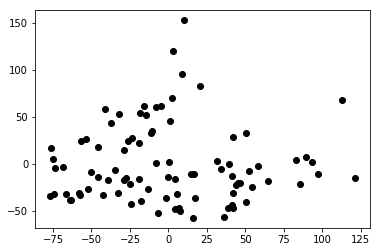

In [25]:
# view the first two components:
plt.plot(pca_transformed[:, 0], pca_transformed[:, 1], 'k.', markersize=12);

In [26]:
num_uniq, uniq_list,treatments,  known_clusters = extract_treatments(df_raw)

14 unique names found:
['FL12' 'SP12' 'FP12' 'FP24' 'FP48' 'FP96' 'SL12' 'SL24' 'SL48' 'SL96'
 'FL06' 'FP06' 'SL06' 'SP06']


In [27]:
# calculate kmeans
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
predicted_clusters = kmeans.fit_predict(pca_transformed)

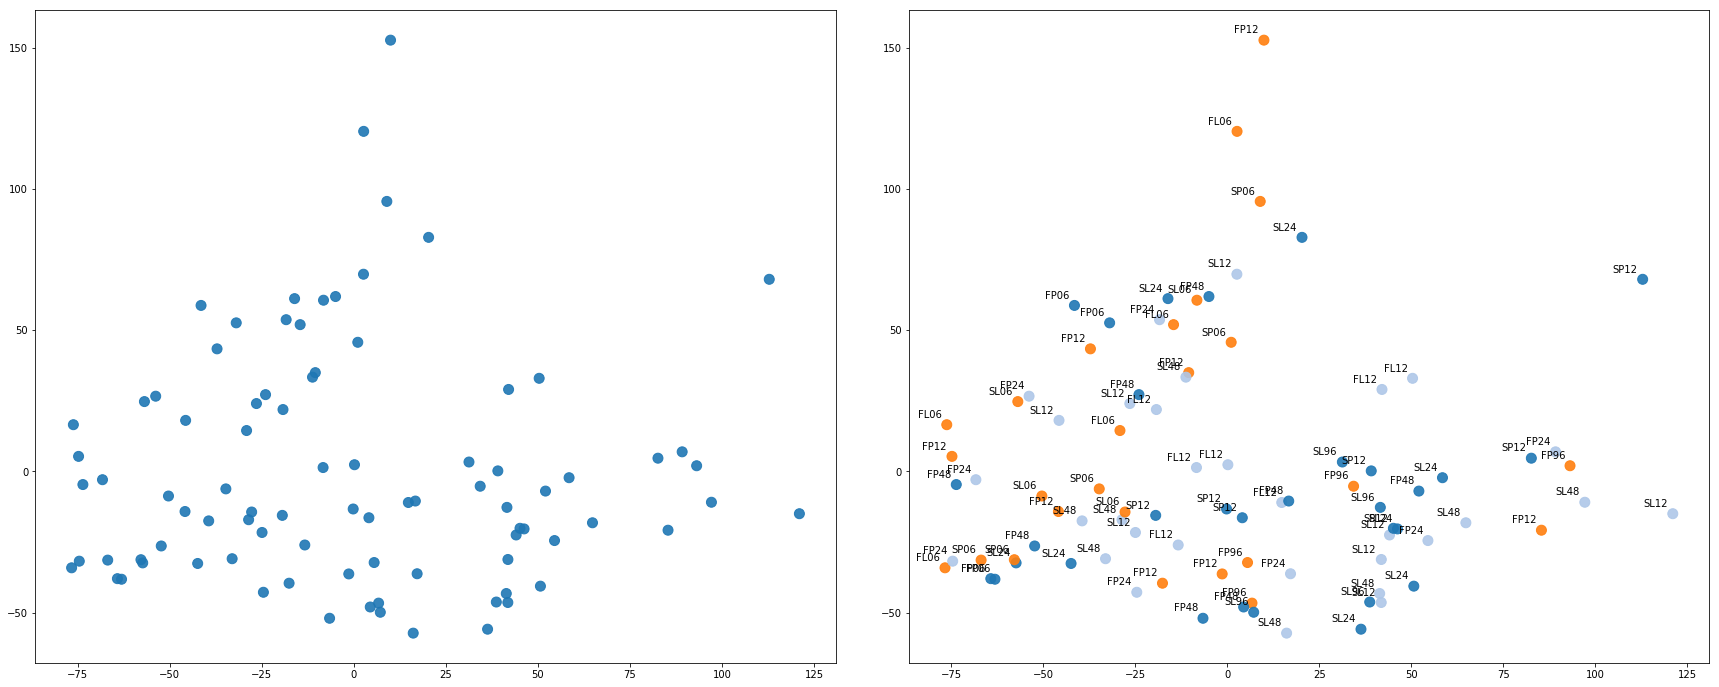

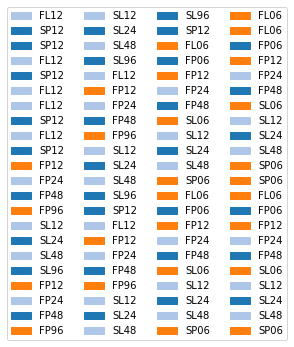

In [28]:
plot_clusters(pca_transformed, known_clusters, predicted_clusters)
show_legend(known_clusters, treatments)

/Users/poxley/anaconda3/envs/bioinformatics/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


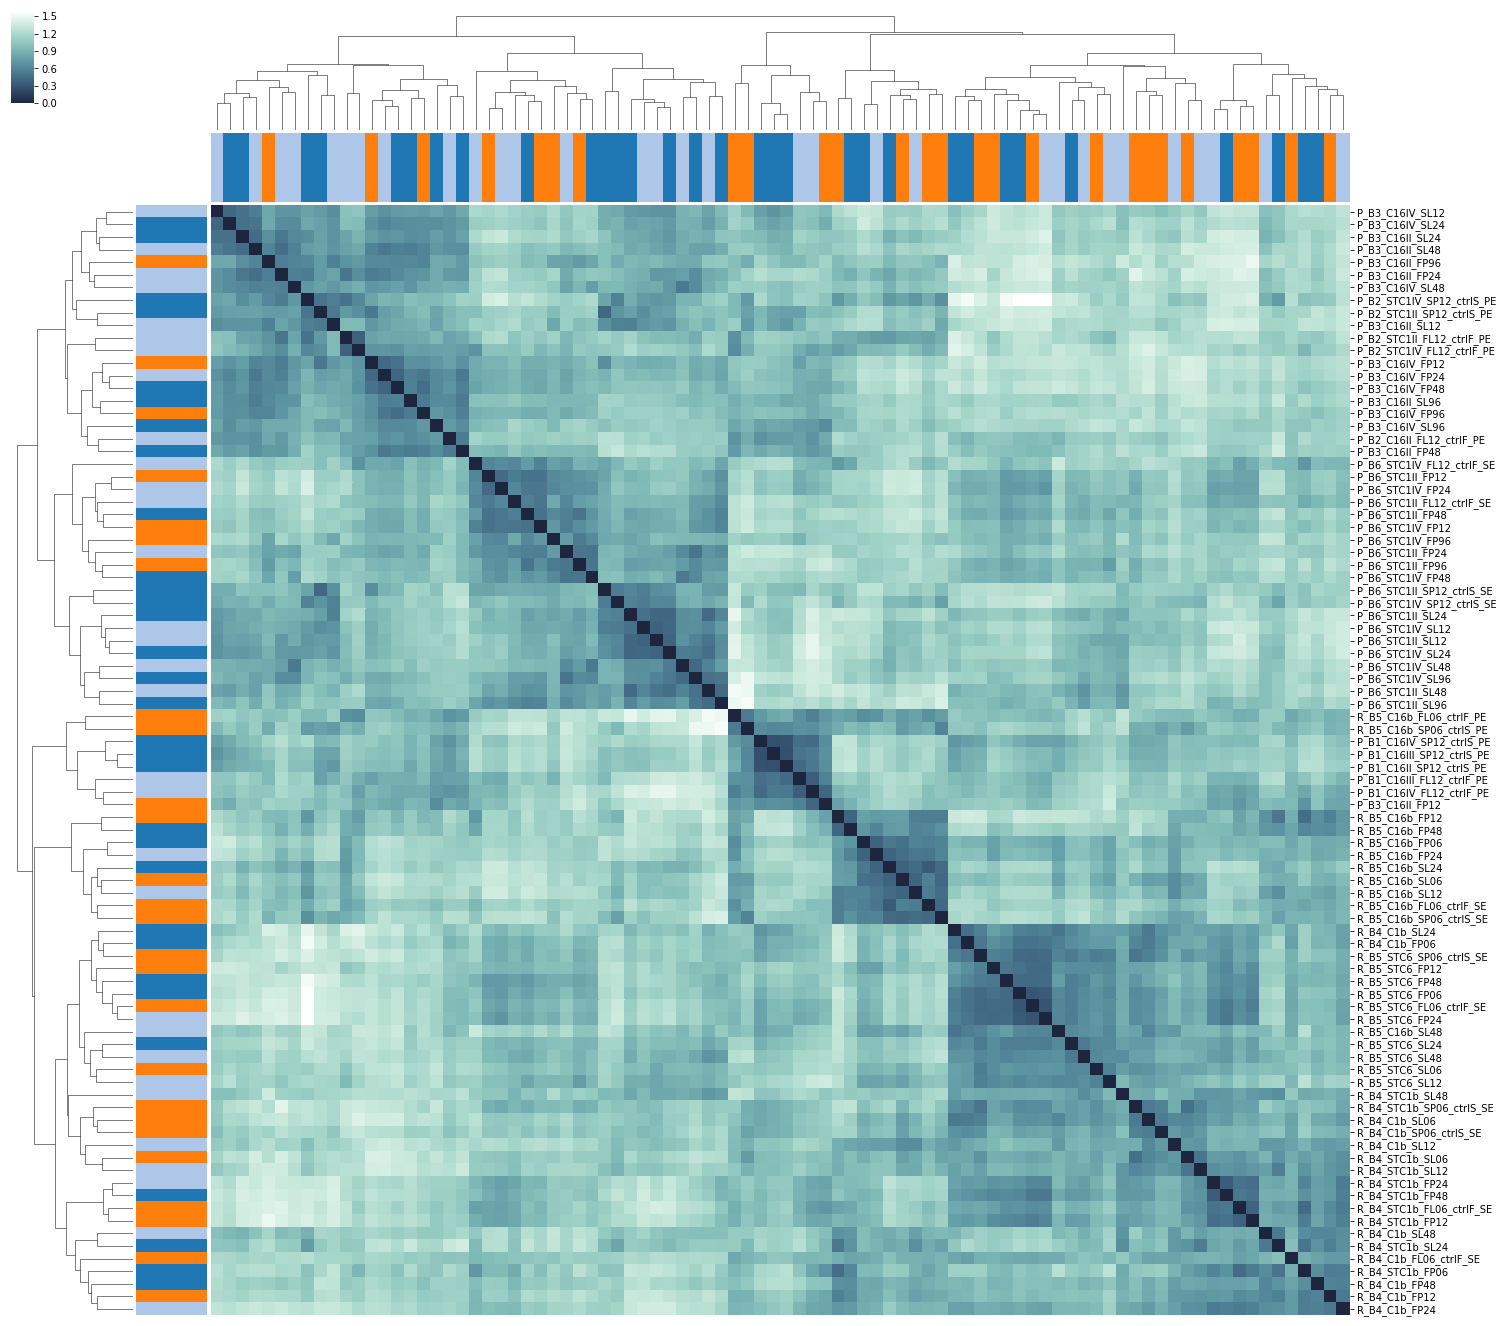

In [29]:
plot_sample_distances(df_raw, pca_transformed, known_clusters, treatments)

# Analysis of mean values (to overcome batch effect clustering)

In [30]:
data_norm = standardize_data(df_mean)

In [31]:
%%time
pca_norm, pca_transformed = pca_transform(data_norm)

CPU times: user 27.5 ms, sys: 5.43 ms, total: 32.9 ms
Wall time: 21.1 ms


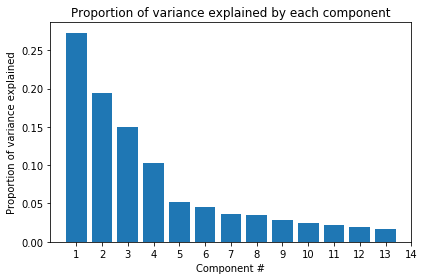

In [32]:
view_pca_contribution(pca_norm)

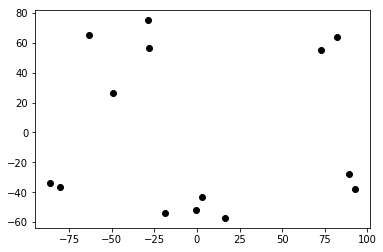

In [33]:
# view the first two components:
plt.plot(pca_transformed[:, 0], pca_transformed[:, 1], 'k.', markersize=12);

In [34]:
num_uniq, uniq_list,treatments,  known_clusters = extract_treatments(df_mean)

14 unique names found:
['FL06' 'FL12' 'FP06' 'FP12' 'FP24' 'FP48' 'FP96' 'SL06' 'SL12' 'SL24'
 'SL48' 'SL96' 'SP06' 'SP12']


In [35]:
# calculate kmeans
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
predicted_clusters = kmeans.fit_predict(pca_transformed)

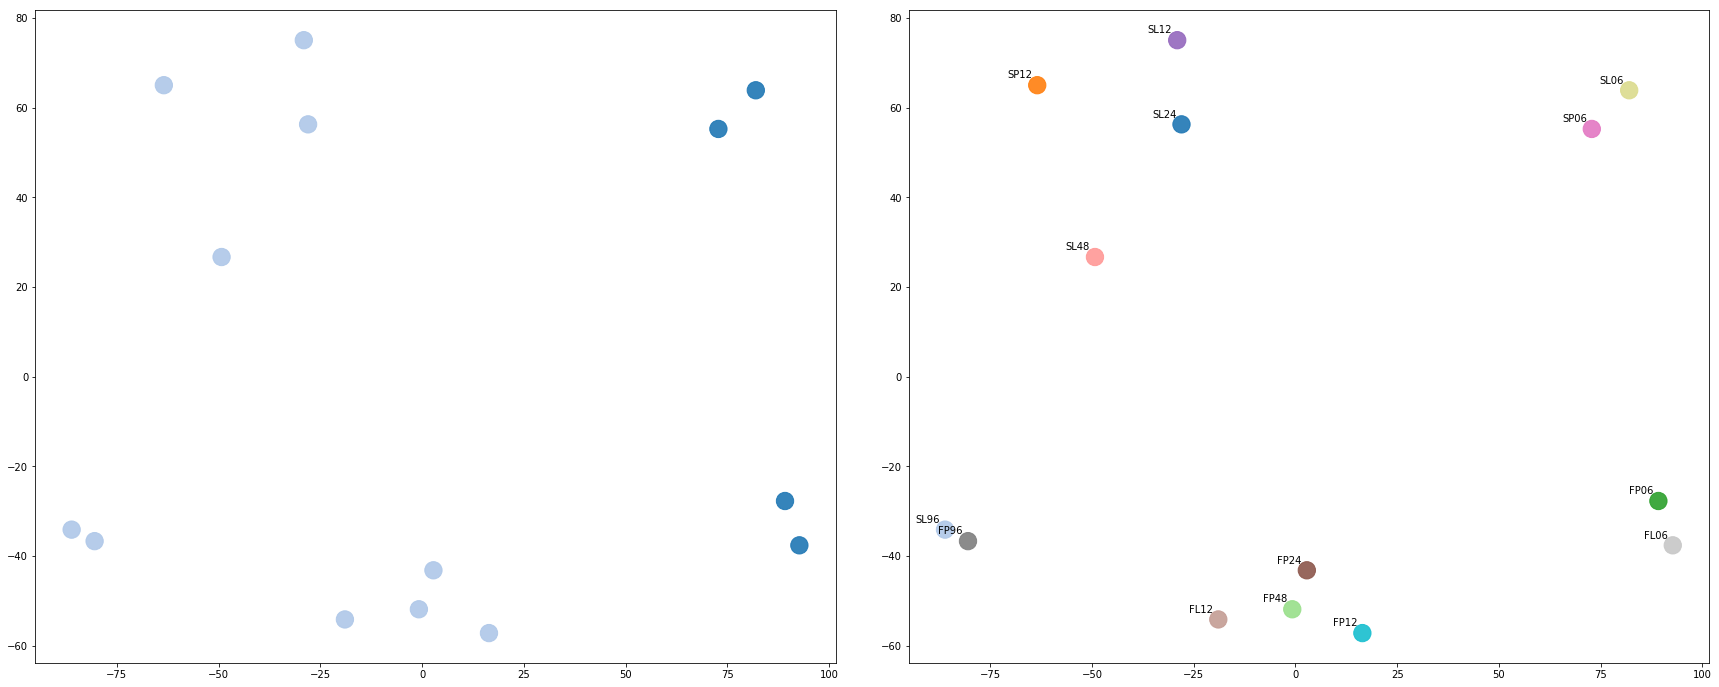

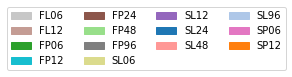

In [36]:
plot_clusters(pca_transformed, known_clusters, predicted_clusters, size=300)
show_legend(known_clusters, treatments)

/Users/poxley/anaconda3/envs/bioinformatics/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


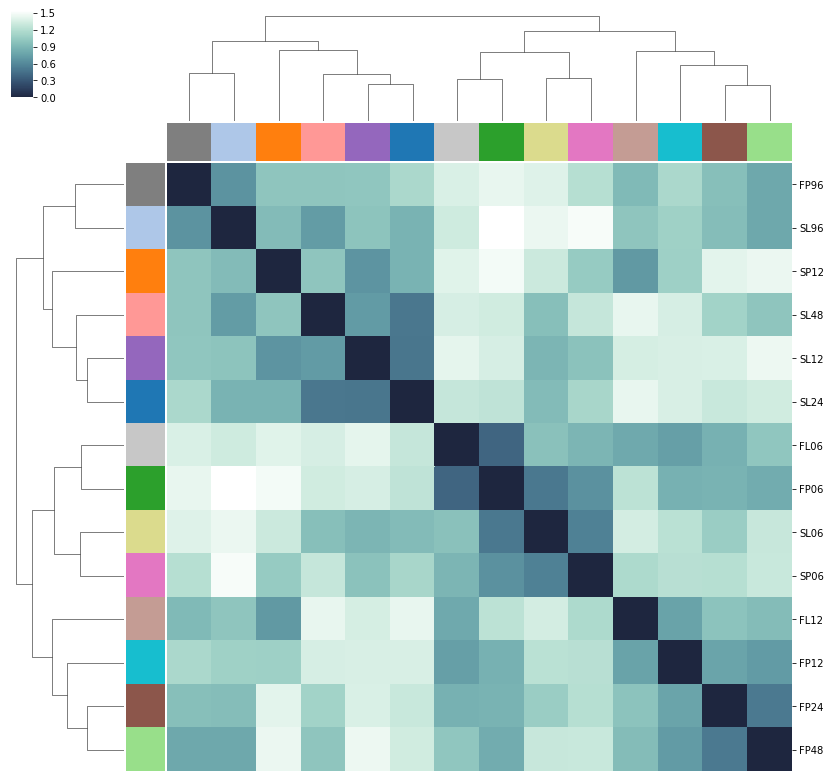

In [37]:
plot_sample_distances(df_mean, pca_transformed, known_clusters, treatments)


## Identification of the genes with 2-fold change in expression:


In [38]:
((df_raw.max(axis=1)/df_raw.min(axis=1)) >= 2).sum()


109

In [39]:
((df_mean.max(axis=1)/df_mean.min(axis=1)) >= 2).sum()

2

In [40]:
df_mean.max(axis=1).head()

LOC105274440     5.120698
LOC105274441     5.148344
LOC105274442    11.051520
LOC105274443     8.309016
LOC105274444    11.557919
dtype: float64

In [41]:
df_mean.min(axis=1).head()

LOC105274440     5.085982
LOC105274441     5.085982
LOC105274442    10.149571
LOC105274443     8.014363
LOC105274444    10.982605
dtype: float64

# Analysis of mean values with the 6-hour timepoints removed

In [42]:
df_mean64 = df_mean[[c for c in df_mean.columns if not re.search('06', c)]]

### Get the list of DEGs:

In [43]:
df_degs = pd.read_csv("../deseq2/broodswap_timecourse.64_treatments.LRT_spline_analysis.pvalues.out",
                      delim_whitespace=True
                     )

In [44]:
degs = df_degs[df_degs.padj <= 0.05].index

In [45]:
df_means64sig = df_mean64.loc[degs,:]

In [46]:
df_means64sig.shape

(596, 10)

### Analysis of DEGs with largest differences in expression

In [54]:
# download gene info (for names)
df_ncbi = pd.read_csv("ooceraea_ncbi_geneinfo_20180717.txt", sep="\t")

In [59]:
df_ncbi["pseudoLOC"] = df_ncbi.GeneID.apply(lambda x: "LOC"+str(x))
df_ncbi = df_ncbi.set_index('pseudoLOC')

In [62]:
df_degsmeannamed = df_means64sig.join(df_ncbi.iloc[:,:-9])

In [94]:
df_means64sig[((df_means64sig.iloc[:,:5].max(axis=1)/
                df_means64sig.iloc[:,:5].min(axis=1)) >= 1.19) |
              ((df_means64sig.iloc[:,5:].max(axis=1)/
                df_means64sig.iloc[:,5:].min(axis=1)) >= 1.19)
             ].join(df_ncbi.iloc[:,:-9])

,FL12,FP12,FP24,FP48,FP96,SL12,SL24,SL48,SL96,SP12,tax_id,Org_name,GeneID,CurrentID,Status,Symbol,Aliases,description,other_designations
LOC105278524,8.754447,9.586422,9.723611,10.459189,10.459051,9.984071,9.678825,9.360714,9.058892,9.949335,2015173.0,Ooceraea biroi,105278524.0,0.0,live,LOC105278524,X777_03507,LIRP,LIRP
LOC105281428_Q,6.968599,7.077103,7.029660,7.913093,13.957358,13.065501,11.977890,11.376211,10.070753,13.897454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LOC105281012,6.666862,6.767800,7.105122,6.967254,6.485398,6.126971,6.411386,6.694685,7.176836,5.869994,2015173.0,Ooceraea biroi,105281012.0,0.0,live,LOC105281012,X777_06321,uncharacterized LOC105281012,uncharacterized protein LOC105281012
LOC105281708,7.499991,7.441525,7.014414,7.195308,7.366836,8.242085,7.462169,7.046541,6.978021,8.372391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LOC105285920,6.379679,6.557716,6.360605,6.386429,8.113190,9.821784,7.577987,6.699763,6.566857,10.246186,2015173.0,Ooceraea biroi,105285920.0,0.0,live,LOC105285920,X777_14208,vegetative cell wall protein gp1,SH3 domain-containing protein C23A1.17|vegetat...
LOC105282036,6.013594,5.878388,5.792649,6.154714,7.528292,6.894637,6.701343,6.403281,6.197056,7.596927,2015173.0,Ooceraea biroi,105282036.0,0.0,live,LOC105282036,X777_08937,G2/mitotic-specific cyclin-B,G2/mitotic-specific cyclin-B
LOC105275344,5.806921,5.915545,5.793278,5.914242,5.943936,6.696004,6.121013,5.996233,5.853117,8.469663,2015173.0,Ooceraea biroi,105275344.0,0.0,live,LOC105275344,X777_00397,ejaculatory bulb-specific protein 3,ejaculatory bulb-specific protein 3
LOC105279314,6.757116,6.430489,6.543121,6.471100,8.503105,6.657728,6.383953,6.109298,6.797838,7.498093,2015173.0,Ooceraea biroi,105279314.0,0.0,live,LOC105279314,X777_05194,trypsin inhibitor,trypsin inhibitor|Carboxypeptidase inhibitor SmCI
LOC105274638,6.481430,6.300810,6.327907,6.395878,7.522024,7.180111,6.938082,6.662250,6.401671,7.337794,2015173.0,Ooceraea biroi,105274638.0,0.0,live,LOC105274638,X777_13566,kinesin-like protein KIF18A,kinesin-like protein KIF18A
LOC105283509,6.239585,6.210220,6.265433,6.417790,7.560974,6.912025,6.677207,6.376442,6.337479,7.215551,2015173.0,Ooceraea biroi,105283509.0,0.0,live,LOC105283509,NaN,zinc finger BED domain-containing protein 1-like,zinc finger BED domain-containing protein 1-like


In [92]:
text = "glycine"
mask = df_means64sig.join(df_ncbi.iloc[:,:-9]
                         ).description.str.contains(text, case=False
                                                   ).fillna(False)

df_result = df_means64sig[mask].join(df_ncbi.iloc[:,:-9]) #
df_result["BR"] = df_result.iloc[:,:5].max(axis=1)/df_result.iloc[:,:5].min(axis=1)
df_result["RB"] = df_result.iloc[:,5:10].max(axis=1)/df_result.iloc[:,:5].min(axis=1)
df_result[["BR", "RB", "description", "other_designations"]]

,BR,RB,description,other_designations
LOC105284539,1.062433,1.077821,sodium- and chloride-dependent glycine transpo...,sodium- and chloride-dependent glycine transpo...
LOC105279559,1.141163,1.154276,glycine receptor subunit alpha-2-like,glycine receptor subunit alpha-2-like
LOC105280202,1.126447,1.112506,glycine-rich cell wall structural protein,glycine-rich cell wall structural protein
LOC105277551,1.175300,1.163596,glycine N-methyltransferase,glycine N-methyltransferase


LOC105276573	1.103559	1.320456	leucine-rich repeat neuronal protein 2
LOC105278524	1.194729	1.140457	LIRP
LOC105276678	1.177337	1.525559	transferrin
LOC105281011	1.027977	1.035362	transferrin
LOC105277056	1.097953	1.087253	neuroparsin-A
LOC105279933	1.394401	1.188637	leucine-rich repeat-containing G-protein coupl...
LOC105279559	1.141163	1.154276	glycine receptor subunit alpha-2-like	

In [80]:
np.log2(1.19)

0.25096157353321874

In [47]:
data_norm = standardize_data(df_means64sig)

In [67]:
%%time
pca_norm, pca_transformed = pca_transform(data_norm)

CPU times: user 2.19 ms, sys: 1.29 ms, total: 3.48 ms
Wall time: 2.45 ms


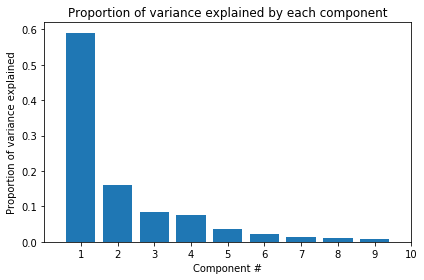

In [68]:
view_pca_contribution(pca_norm)

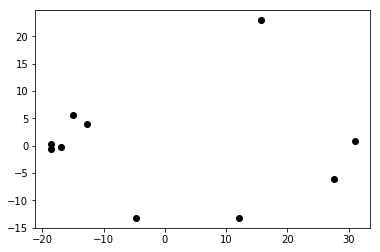

In [69]:
# view the first two components:
plt.plot(pca_transformed[:, 0], pca_transformed[:, 1], 'k.', markersize=12);

In [70]:
num_uniq, uniq_list,treatments,  known_clusters = extract_treatments(df_means64sig)

10 unique names found:
['FL12' 'FP12' 'FP24' 'FP48' 'FP96' 'SL12' 'SL24' 'SL48' 'SL96' 'SP12']


In [71]:
# calculate kmeans
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
predicted_clusters = kmeans.fit_predict(pca_transformed)

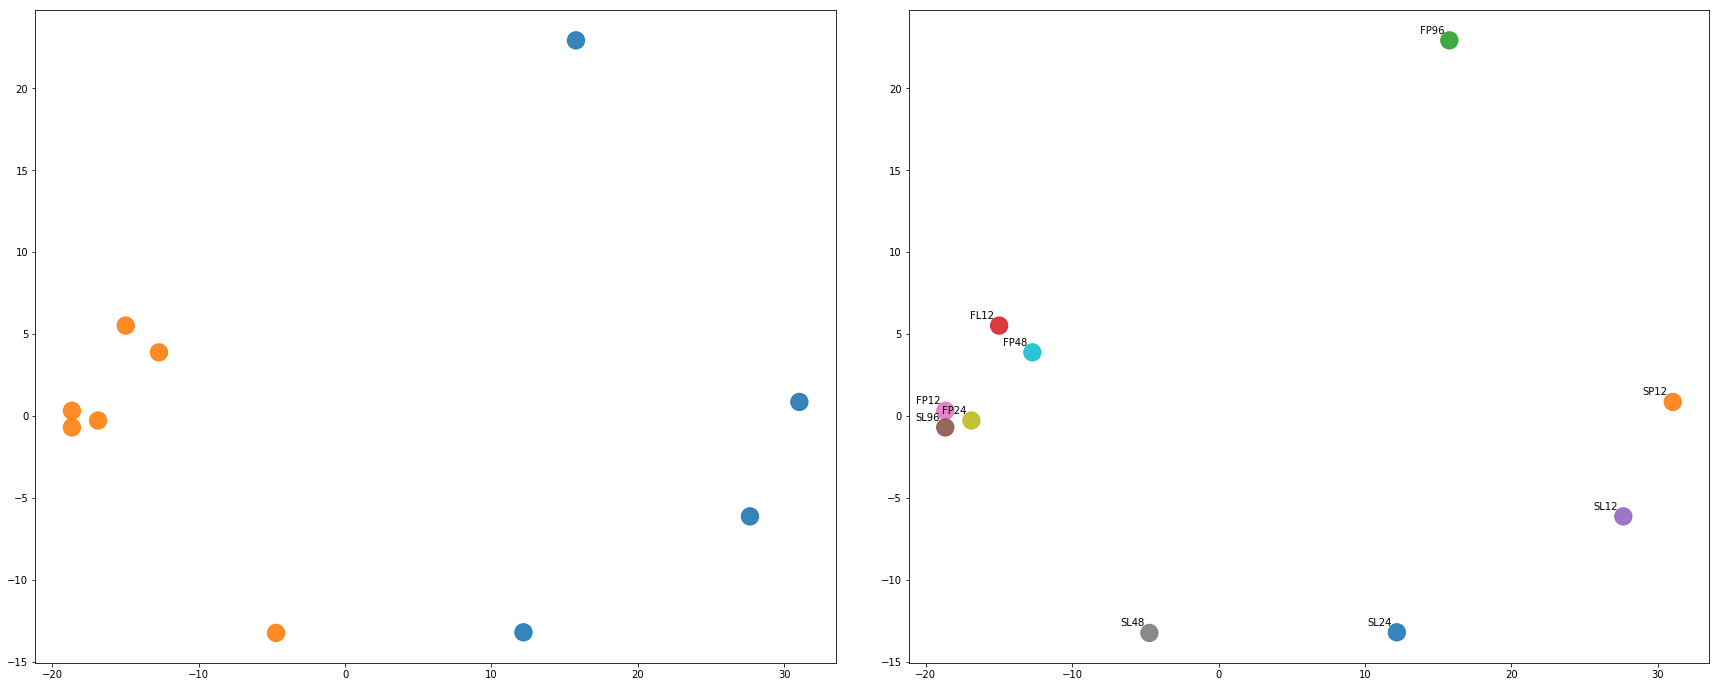

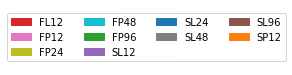

In [72]:
plot_clusters(pca_transformed, known_clusters, predicted_clusters, size=300)
show_legend(known_clusters, treatments)

/Users/poxley/anaconda3/envs/nlp/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


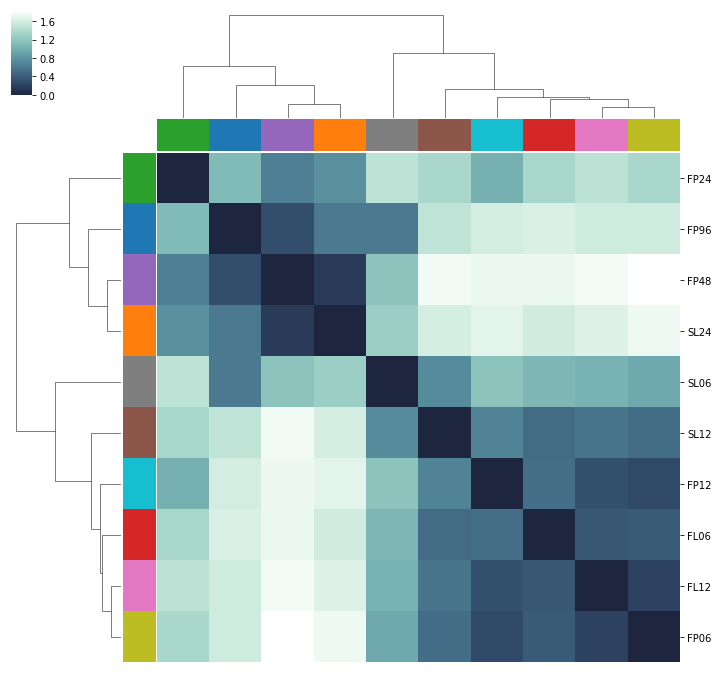

In [73]:
plot_sample_distances(df_mean, pca_transformed, known_clusters, treatments)


(10, 596)


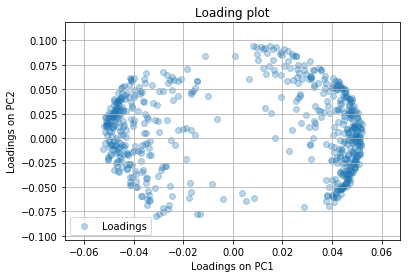

In [91]:
data_n = standardize_data(df_means64sig)
pca_fl = PCA()
pca_fl.fit(data_n)

# from http://www.nxn.se/valent/loadings-with-scikit-learn-pca
loadings = pca_fl.components_
print(loadings.shape)

# I've omitted the code to create ind; a list of the indexes of the
# loadings ordered by distance from origin.

plt.scatter(loadings[0],
            loadings[1],
            alpha=0.3, label="Loadings");
#plt.scatter(loadings[:, ind[:3]], c='r', marker='o',
#            s=80, linewidths=1, facecolors="none", 
#            edgecolors='r', 
#            label="Contributes most\nto variance");

plt.title("Loading plot");
plt.xlabel("Loadings on PC1");
plt.ylabel("Loadings on PC2");
plt.grid();
plt.legend(loc='lower left');

## Get the individual DEGs 

In [92]:
len([l for l in loadings[0] if l<0 ])

263

In [93]:
len([l for l in loadings[0] if l>0 ])

333

In [95]:
df_bc2r = pd.read_csv("../deseq2/broodswap_time_series.forg2stat.genes.batch_corrected.pvalues.out",
                      delim_whitespace=True,
                     )

In [96]:
df_r2bc = pd.read_csv("../deseq2/broodswap_time_series.stat2forg.genes.batch_corrected.pvalues.out",
                      delim_whitespace=True,
                     )

In [98]:
degs_bc2r = df_bc2r[df_bc2r.padj <= 0.05].index
degs_r2bc = df_r2bc[df_r2bc.padj <= 0.05].index
print(len(degs_bc2r))
print(len(degs_r2bc))

257
2311


In [103]:
bc2r_uniq = (set(degs_bc2r).intersection(set(degs_r2bc)))

In [135]:
common = (set(degs_bc2r) - set(degs_r2bc))

In [105]:
r2bc_uniq = (set(degs_r2bc) - set(degs_bc2r))

In [113]:
b2r_itsxn = df_means64sig.index.isin(bc2r_uniq)

In [118]:
loadings[:,b2r_itsxn][0]

76

In [140]:
r2b_itsxn = df_means64sig.index.isin(r2bc_uniq)

In [141]:
com_itsxn = df_means64sig.index.isin(common)

(10, 596)


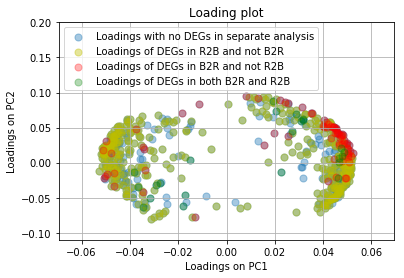

In [146]:
data_n = standardize_data(df_means64sig)
pca_fl = PCA()
pca_fl.fit(data_n)

# from http://www.nxn.se/valent/loadings-with-scikit-learn-pca
loadings = pca_fl.components_
print(loadings.shape)

# I've omitted the code to create ind; a list of the indexes of the
# loadings ordered by distance from origin.

plt.scatter(loadings[0],
            loadings[1],
            alpha=0.4, 
            s=50,
            label="Loadings with no DEGs in separate analysis");
plt.scatter(loadings[:,r2b_itsxn][0],
            loadings[:,r2b_itsxn][1],
            c='y', marker='o',
            s=50, alpha=0.4,
            linewidths=1, facecolors="none", 
            edgecolors='y', 
            label="Loadings of DEGs in R2B and not B2R");
plt.scatter(loadings[:,b2r_itsxn][0],
            loadings[:,b2r_itsxn][1],
            c='r', marker='o',
            s=50, alpha=0.3,
            linewidths=1, facecolors="none", 
            edgecolors='r', 
            label="Loadings of DEGs in B2R and not R2B");

plt.scatter(loadings[:,com_itsxn][0],
            loadings[:,com_itsxn][1],
            c='g', marker='o',
            s=50, alpha=0.3,
            linewidths=1, facecolors="none", 
            edgecolors='g', 
            label="Loadings of DEGs in both B2R and R2B");


plt.title("Loading plot");
plt.xlabel("Loadings on PC1");
plt.ylabel("Loadings on PC2");
plt.ylim((-0.11,0.2))
plt.grid();
plt.legend(loc='upper left');

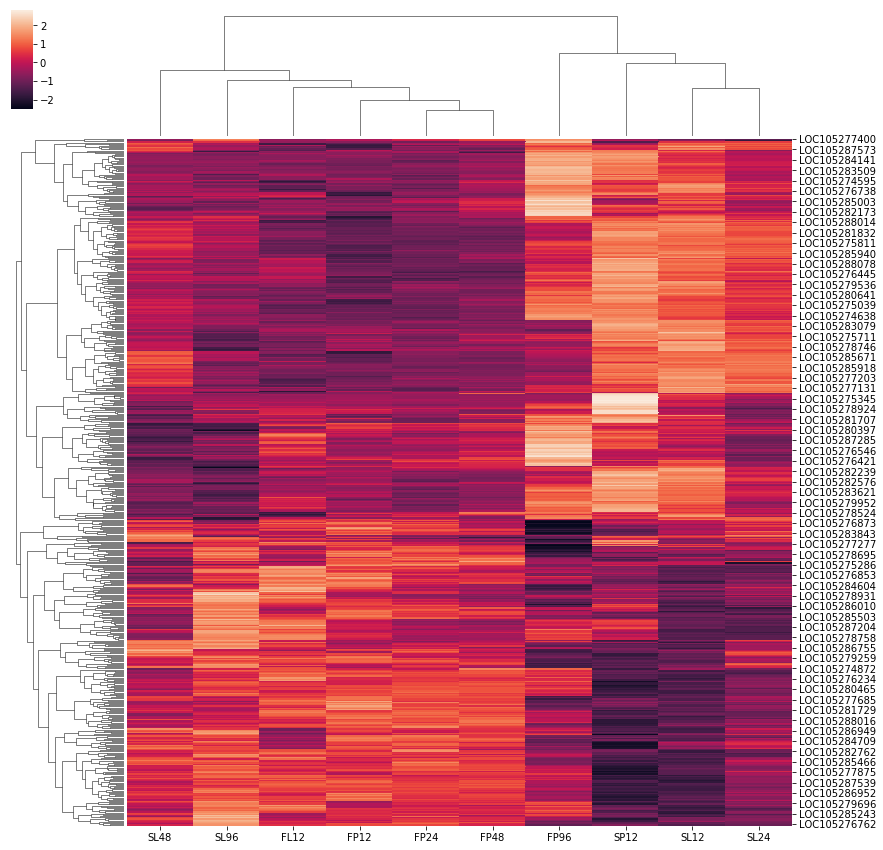

In [147]:
sns.clustermap(method='complete', metric='euclidean',
                data=df_means64sig, z_score=0, 
               figsize=(14,15)
              )